<a href="https://colab.research.google.com/github/snghynn/ESAA-YB/blob/main/BOOK_%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD_%EA%B0%80%EC%9D%B4%EB%93%9C_pg_227~251%2Cpg_278~289.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

파이썬 머신러닝 완벽 가이드_pg.227 ~ 251, pg.278 ~ 289

## 6. XGBoost(eXtra Gradient Boost)

- 분류에 있어서 일반적으로 다른 머신러닝보다 뛰어난 예측 성능을 나타냄

- GBM의 단점인 느린 수행시간 및 과적합 규제(Regularization) 부재 등의 문제를 해결
- CPU 병렬 학습이 가능해 기존 GBM보다 빠르게 학습 완료 가능
- 장점
  - 뛰어난 예측 성능
  - GBM 대비 빠른 수행 시간
  - 과적합 규제(Regularization)
  - Tree pruning
  - 자체 내장된 교차 검증
  - 결손값 자체 처리




In [28]:
import xgboost as xgb
from xgboost import XGBClassifier

#### 파이썬 래퍼 XGBoost 하이퍼 파라미터
- GBM과 유사한 하이퍼 파라미터 + 조기 중단, 과적합을 규제하기 위한 파라미터
- 일반 파라미터: 일반적으로 실행 시 스레드의 개수나 silent 모드 등의 선택을 위한 파라미터로서 디폴트 파라미터 값을 바꾸는 경우는 거의 없음
  - booster
  - silent
  - nthread
- 부스트 파라미터: 트리 최적화, 부스팅, regularization 등과 관련 파라미터 등을 지칭
  - eta
  - num_boost_rounds
  - min_child_weight
  - gamma
  - max_depth
  - sub_sample
  - colsample_bytree
  - lambda
  - alpha
  - scale_pos_weight
- 학습 테스크 파라미터: 학습 수행 시의 객체 함수, 평가를 위한 지표 등을 설정하는 파라미터
  - objective
  - binary
  - multi
  - eval_metric


- 수행 속도를 향상시키기 위한 early stopping 기능
- n_estimators: 지정된 횟수만큼 반복적으로 학습 오류를 감소
  +조기중단 파라미터 값(num_rounds)을 설정해 부스팅 더이상 진행하지 않고 종료 가능

In [29]:
import xgboost
print(xgboost.__version__)

1.7.5


### 파이썬 래퍼 XGBoost 적용 - 위스콘신 유방암 예측
- 종양의 크기, 모양 등의 다양한 속성값을 기반으로 악성(malignant)인지 양성 종양(benign)인지를 분류한 데이터 세트

In [30]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [31]:
dataset=load_breast_cancer()
X_features=dataset.data
y_label=dataset.target
cancer_df=pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']=y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [32]:
# 레이블 값의 분포 확인
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [33]:
# 전체 데이터 세트 중 80%는 학습용 데이터, 20%는 테스트용 데이터
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [34]:
# 데이터 인터페이스를 위해 DataFrame.values를 이용해 넘파이로 일차 변환한 뒤에 DMatrix 변환 적용
dtrain=xgb.DMatrix(data=X_train, label=y_train)
dtest=xgb.DMatrix(data=X_test, label=y_test)

In [35]:
params={'max_depth':3,  # 트리의 최대 깊이: 3
        'eta':0.1,  # learning rate
        'objective':'binary:logistic',  # 0,1의 이진 분류
        'eval_metric':'logloss',  # 오류 함수의 평가 성능 지표
        'early_stoppings':100 
        }
num_rounds=400  # 부스팅 반복 횟수

In [36]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기
wlist=[(dtrain, 'train'), (dtest, 'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model=xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, early_stopping_rounds=100, evals=wlist)

[05:09:56] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stoppings" } are not used.

[0]	train-logloss:0.60969	eval-logloss:0.61352
[1]	train-logloss:0.54080	eval-logloss:0.54784
[2]	train-logloss:0.48375	eval-logloss:0.49425
[3]	train-logloss:0.43446	eval-logloss:0.44799
[4]	train-logloss:0.39055	eval-logloss:0.40911
[5]	train-logloss:0.35415	eval-logloss:0.37498
[6]	train-logloss:0.32122	eval-logloss:0.34571
[7]	train-logloss:0.29259	eval-logloss:0.32053
[8]	train-logloss:0.26747	eval-logloss:0.29721
[9]	train-logloss:0.24515	eval-logloss:0.27799
[10]	train-logloss:0.22569	eval-logloss:0.26030
[11]	train-logloss:0.20794	eval-logloss:0.24604
[12]	train-logloss:0.19218	eval-logloss:0.23156
[13]	train-logloss:0.17792	eval-logloss:0.22005
[14]	train-logloss:0.16522	eval-logloss:0.20857
[15]	train-logloss:0.15362	eval-logloss:0.19999
[16]	train-logloss:0.14333	eval-logloss:0.19012
[17]	train-logloss:0.13398	eval-logloss:0.18182
[18]	train-logloss:0.12560	eval-logloss:0.17473
[19]	

- train()으로 학습 수행 반복 시 train-error와 eval-logloss가 지속적으로 감소
- predict() 매서드는 예측 결과 클래스 값(0과 1)을 반환하는 데 반해 xgboost의 predict()는 예측 결괏값이 아닌 예측 결과를 추정할 수 있는 확률 값을 반환
- 본 예제는 이진 분류이므로 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측 값 결정하는 로직 추가

In [37]:
pred_probs=xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds=[1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [38]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [39]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


### xgboost 패키지에 내장된 시각화 기능 수행 

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

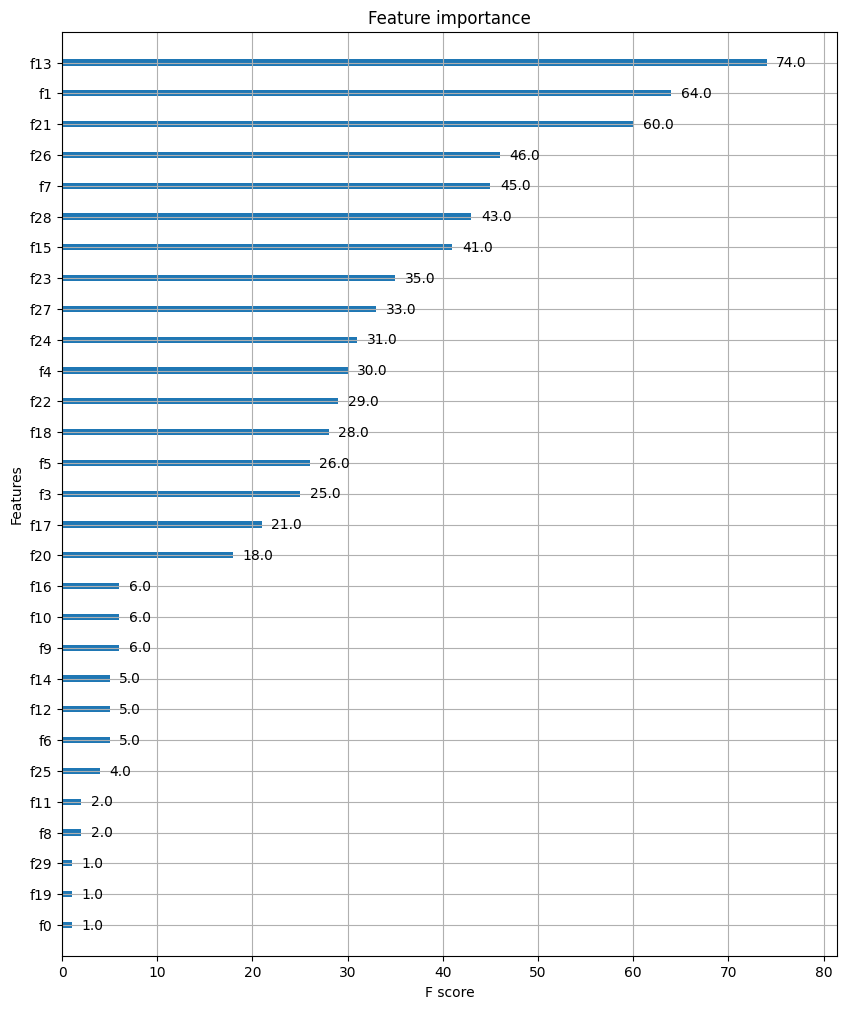

In [40]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax=plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)  #피처의 중요도를 막대 그래프 형식으로 나타냄
# 피처명을 제대로 알 수 없으므로 f0, f1과 같이 피처 순서별로 f자 뒤에 순서 붙임. f0은 첫번째, f1는 두번째, ...

## 위스콘신 대학병원의 유방암 데이터 세트 예측

In [41]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier
xgb_wrapper=XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds=xgb_wrapper.predict(X_test)
w_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

In [42]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


In [43]:
# 평가를 위한 데이터 세트로 테스트 데이터 세트 사용. But 테스트 데이터 학습 시에는 완전히 알려지지 않은 데이터 세트를 사용해야 과적합을 피할 수 있음
from xgboost import XGBClassifier

xgb_wrapper=XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals=[(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
ws100_preds=xgb_wrapper.predict(X_test)
ws100_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

> 211번 반복 시 logloss가 0.0855이고 311번 반복시 logloss가 0.085948인데 211번에서 311번까지 early_stopping_rounds=100으로 지정된 100번의 반복 동안 성능 평가 지수가 향상되지 않았기 때문.

In [44]:
# 조기 중단으로 학습된 XGBCllassifier의 예측 성능 살펴보기
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


> 조기 중단이 적용되지 않은 결과보다 약간 저조한 성능을 나타냈지만, 큰 차이는 아님.

But, 조기 중단값을 너무 급격하게 줄이면 예측 성능이 저하될 우려가 있음

In [45]:
# early_stopping_rounds를 10으로 설정하고 재학습
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='logloss', eval_set=evals, verbose=True)

ws10_preds=xgb_wrapper.predict(X_test)
ws10_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

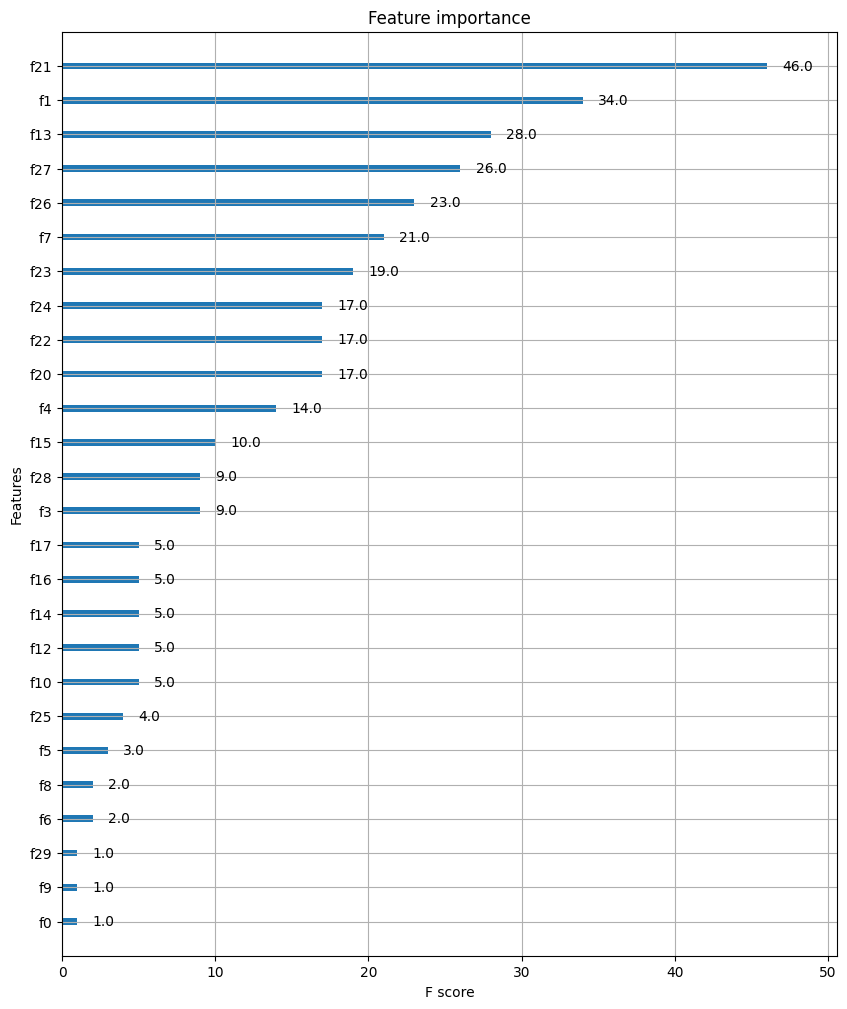

In [46]:
# plot_importance()에서도 xgboost의 plot_importance 사용 결과와 동일
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax=plt.subplots(figsize=(10,12))

#사이킷런 Wrapper 클래스를 입력해도 무방
plot_importance(xgb_wrapper, ax=ax)

## 07. LightGBM
- XGBoost보다 학습에 걸리는 시간이 훨씬 적음
- 메모리 사용량도 상대적으로 적음
- LightGBM과 XGBoost의 예측 성능은 별다른 차이가 없고, 기능상의 다양성이 오히려 많음
- 일반 GBM 계열의 트리 분할 방법과 다르게 리프 중심 트리 분할 방식을 사용
- 리프 중심 트리 분할: 트리의 균형을 맞추지 않고, 최대 손실 값을 가지는 리프 노드를 지속적으로 분할하면서 트리의 깊이가 깊어지고 비대칭적인 규칙트리 생성

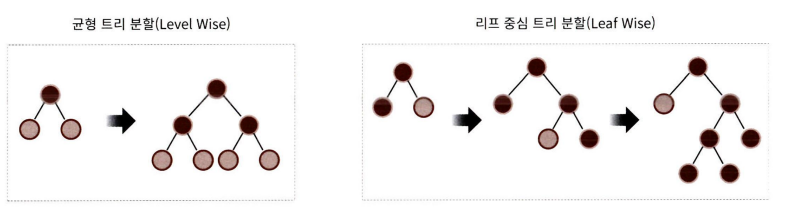

#### 하이퍼 파라미터 튜닝 방안
- num_leaves: 개별 트리가 가질 수 있는 최대 리프의 개수. 개수를 높이면 정확도가 높아지지만, 반대로 트리의 깊이가 깊어지고 모델이 복잡도가 커져 과적합 영향도 커짐
- min_data_in_leaf
- max_depth
- learning_rate을 작게 하면서 n_estimators를 크게 하기(과적합 유념)


### LightGBM 적용-위스콘신 유방암 예측

In [47]:
#LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset=load_breast_cancer()
ftr=dataset.data
target=dataset.target

In [49]:
# 80%는 학습용, 20%는 테스트용 데이터 추출 
X_train, X_test, y_train, y_test=train_test_split(ftr, target, test_size=0.2, random_state=156)

# 앞서 XGBoost와 동일하게 n_estmators는 400 설정
lgbm_wrapper=LGBMClassifier(n_estimators=400)
# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능
evals=[(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
pred=lgbm_wrapper.predict(X_test)
pred_proba=lgbm_wrapper.predict_proba(X_test)[:,1]

[1]	valid_0's binary_logloss: 0.565079
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_logloss: 0.151113
[25]	valid_0's binary_logloss: 0.148395
[26]	vali

> 조기 중단으로 147번 반복까지만 수행하고 학습 종료

In [50]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9905


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

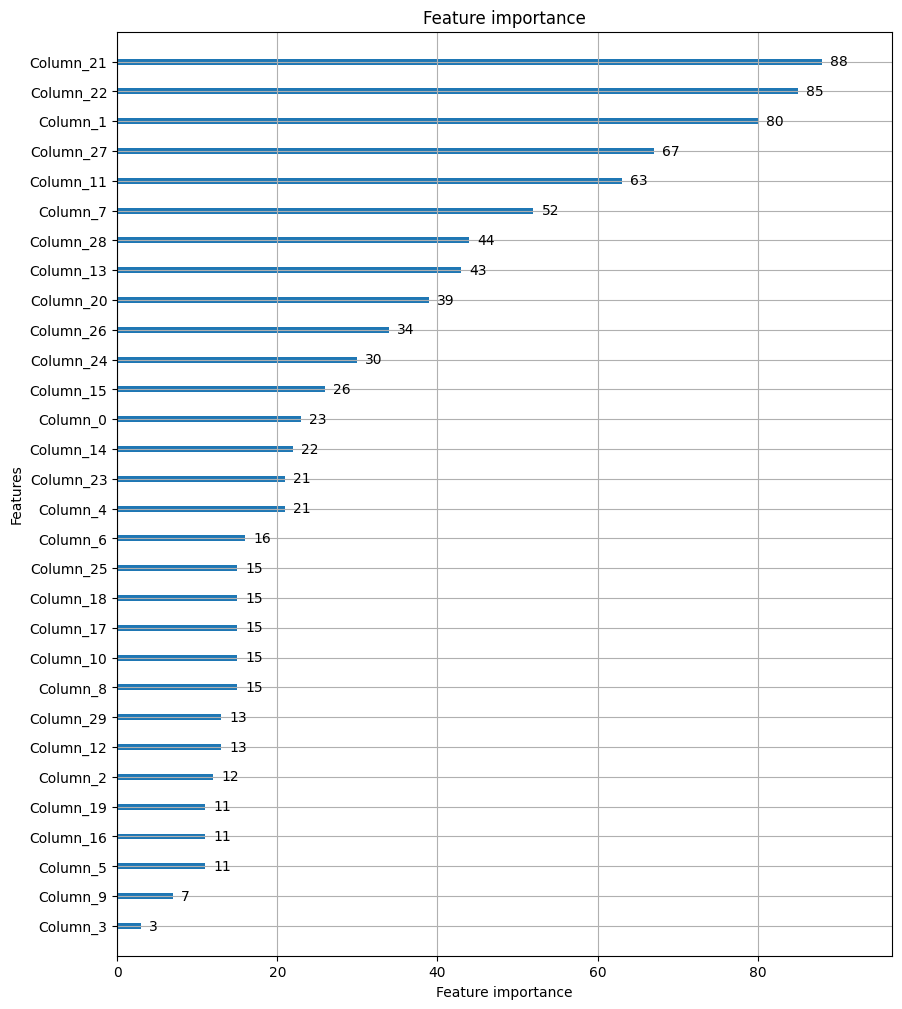

In [51]:
# plot_importance()를 이용해 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax=plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)

pg.278~289

## 10. 스태킹 앙상블
- 스태킹: 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행
- 개별 알고리즘의 예측 결과 데이터 세트를 최종적인 메타 데이터 세트로 만들어 별도의 ML 알고리즘으로 최종 학습을 수행

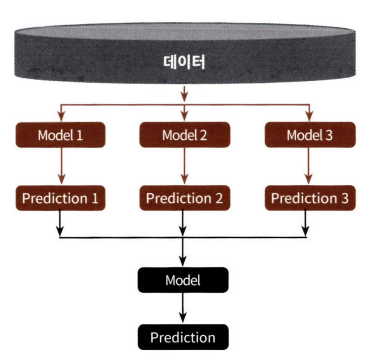

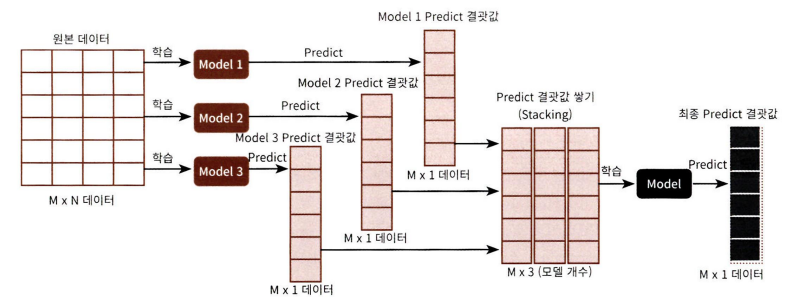

#### 기본 스태킹 모델

In [53]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data=load_breast_cancer()
X_data=cancer_data.data
y_label=cancer_data.target

X_train, X_test, y_train, y_test=train_test_split(X_data, y_label, test_size=0.2, random_state=0)

In [58]:
# 개별 ML 모델 생성
knn_clf=KNeighborsClassifier(n_neighbors=4)
rf_clf=RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf=DecisionTreeClassifier()
ada_clf=AdaBoostClassifier(n_estimators=100)

#스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final=LogisticRegression(C=10)

In [59]:
# 개별 모델들 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [61]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred=knn_clf.predict(X_test)
rf_pred=rf_clf.predict(X_test)
dt_pred=dt_clf.predict(X_test)
ada_pred=ada_clf.predict(X_test)

print('KNN 정확도:{0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도:{0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도:{0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도:{0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도:0.9211
랜덤 포레스트 정확도:0.9649
결정 트리 정확도:0.9035
에이다부스트 정확도:0.9561


In [62]:
# 최종 메타 모델인 로지스틱 회귀에서 학습 데이터로 다시 사용
pred=np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

#transpose를 이용해 행과 열의 위치 교환. 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦
pred=np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [63]:
# 최종 메타 모델인 로지스틱 회귀를 학습하고 예측 정확도 측정
lr_final.fit(pred, y_test)
final=lr_final.predict(pred)
print('최종 메타 모델의 예측 정확도:{0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도:0.9737


> 최종 메타 모델에서 학습하고 예측한 결과, 정확도가 개별 모델 정확도보다 향상됨


#### CV 세트 기반의 스태킹
- 과적합 개선 위해 최종 메타 모델을 위한 데이터 세트를 만들 때 교차 검증 기반으로 예측된 결과 데이터 세트를 이용
- 개별 모델들이 각각 교차 검증으로 메타 모델을 위한 학습용 스태킹 데이터 생성과 예측을 위한 테스트용 스태킹 데이터를 생성한 뒤 이를 기반으로 메타 모델이 학습과 예측을 수행

In [74]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf=KFold(n_splits=n_folds, shuffle=True, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr=X_train_n[train_index] 
        y_tr=y_train_n[train_index] 
        X_te=X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :]=model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter]=model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean=np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [76]:
knn_train, knn_test=get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test=get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test=get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)    
ada_train, ada_test=get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
DecisionTreeClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
AdaBoostClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 


In [77]:
# 스텝 2 구현
# concatenate(): 여러 넘파이 배열 합쳐줌
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


- 최종 메타 모델인 로지스틱 회귀를 스태킹된 학습용 피처 데이터 세트와 원본 학습 레이블 데이터로 학습 후에 스테킹된 테스트 데이터 세트로 예측. 이후 결과를 원본 테스트 레이블 데이터와 비교해 정확도 측정

In [78]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737


## 11. 정리
- 대부분의 앙상블: 결정 트리 기반의 Weak Learner를 결합해 변동성을 줄여 예측 오류를 줄이고 성능 개선
- 결정 트리 알고리즘: 정보의 균일도에 기반한 규칙 트리 만들어 예측 수행
  - 다른 알고리즘에 비해 직관적
  - (단점): 균일한 최종 결과 예측 결과 도출 위해 결정 트리가 깊어지고 복잡해지며 과적합 쉽게 발생
- 앙상블_배깅: 학습 데이터를 중복 허용, 다수의 세트로 샘플링하여 이를 다수의 weak learner가 학습한 뒤 최종 결과를 결합해 예측
  - 랜덤 포레스트: 수행시간 빠르고 비교적 안정적인 예측 성능 제공
- 앙상블_부스팅: 학습기들이 순차적으로 학습을 진행하면서 예측이 틀린 데이터에 대해서는 가중치를 부여해 다음번 학습기가 학습할 때에는 이전에 예측이 틀린 데이터에 대해서는 보다 높은 정확도로 예측
  - GBM: 뛰어난 예측 성능, but 수행 시간이 너무 오래 걸림
  - XGBoost
  - LightGBM
- 스태킹: 여러 개의 개별 모델들이 생성한 예측 데이터를 기반으로 최종 메타 모델이 학습할 별도의 학습 데이터 세트와 예측할 테스트 데이터 세트를 재생성하는 기법 